<a href="https://colab.research.google.com/github/ShaeXP/Ports/blob/master/AI_Influencer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### make sure that CUDA is available in Edit -> Nootbook settings -> GPU
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla T4, 15360 MiB, 14913 MiB


In [2]:
### Dependency installations
!update-alternatives --install /usr/local/bin/python3 python3 /usr/bin/python3.8 2
!update-alternatives --install /usr/local/bin/python3 python3 /usr/bin/python3.9 1
!sudo apt install python3.8

!sudo apt-get install python3.8-distutils

!python --version

!apt-get update

!apt install software-properties-common

!sudo dpkg --remove --force-remove-reinstreq python3-pip python3-setuptools python3-wheel

!apt-get install python3-pip

print('Git clone project and install requirements...')
!git clone https://github.com/Winfredy/SadTalker &> /dev/null
%cd SadTalker
!export PYTHONPATH=/content/SadTalker:$PYTHONPATH
!python3.8 -m pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113
!apt update
!apt install ffmpeg &> /dev/null
!python3.8 -m pip install -r requirements.txt
!pip install openai
!pip install gtts
!pip install diffusers accelerate transformers
!pip install requests

update-alternatives: error: alternative path /usr/bin/python3.8 doesn't exist
update-alternatives: error: alternative path /usr/bin/python3.9 doesn't exist
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpython3.8-minimal libpython3.8-stdlib python3.8-minimal
Suggested packages:
  python3.8-venv binfmt-support
The following NEW packages will be installed:
  libpython3.8-minimal libpython3.8-stdlib python3.8 python3.8-minimal
0 upgraded, 4 newly installed, 0 to remove and 37 not upgraded.
Need to get 5,076 kB of archives.
After this operation, 18.8 MB of additional disk space will be used.
Get:1 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 libpython3.8-minimal amd64 3.8.20-1+jammy1 [796 kB]
Get:2 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 python3.8-minimal amd64 3.8.20-1+jammy1 [2,023 kB]
Get:3 https://ppa.launchpadcontent.net

In [3]:
### Models used for lisyncing
print('Download pre-trained models...')
!rm -rf checkpoints
!bash scripts/download_models.sh

Download pre-trained models...
--2026-02-11 02:57:31--  https://github.com/OpenTalker/SadTalker/releases/download/v0.0.2-rc/mapping_00109-model.pth.tar
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/569518584/ccc415aa-c6f4-47ee-8250-b10bf440ba62?sp=r&sv=2018-11-09&sr=b&spr=https&se=2026-02-11T03%3A51%3A41Z&rscd=attachment%3B+filename%3Dmapping_00109-model.pth.tar&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2026-02-11T02%3A51%3A23Z&ske=2026-02-11T03%3A51%3A41Z&sks=b&skv=2018-11-09&sig=cgZCpIYAarIQ5zWBS3uiqm5sKoUWLegkoRmKuaciJEw%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc3MDc4MjI1MSwibmJmIjo

## Setup API Keys

Before running the next cell, you need to add your OpenAI API key:

**Option 1 (Recommended): Use Colab Secrets**
1. Click the 🔑 key icon in the left sidebar
2. Click "+ Add new secret"
3. Name: `OPENAI_API_KEY`
4. Value: Your OpenAI API key from https://platform.openai.com/api-keys
5. Toggle "Notebook access" ON

**Option 2: Direct Input**
Replace `your-openai-api-key-here` in the code below with your actual key.

In [30]:
import json
from openai import OpenAI

# --- Get keys from Colab Secrets (recommended) ---
OPENAI_API_KEY = None
HF_TOKEN = None
try:
    from google.colab import userdata
    OPENAI_API_KEY = userdata.get("OPENAI_API_KEY")
    HF_TOKEN = userdata.get("HF_TOKEN")
except Exception:
    pass

if not OPENAI_API_KEY:
    raise ValueError("OPENAI_API_KEY is missing. Add it in Colab Secrets (left sidebar key icon).")

client = OpenAI(api_key=OPENAI_API_KEY)
print("✓ OpenAI client initialized successfully!")

def get_prompt_for_image(avatar_characteristics: str) -> str:
    """
    Convert avatar characteristics into a clean image-generation prompt.
    Returns: output_prompt (string)
    """
    prompt = f"""Given below are some characteristics of a person for a single scene in a video.
Return a prompt for an image-generation model to generate an image of the person based on the given characteristics.

Guidelines for the image:
Photoreal head-and-shoulders portrait of a 29-year-old East Asian-American woman with straight dark hair (center part, low bun), thin rectangular black glasses, minimal makeup, small stud earrings, plain light-gray tee. Calm friendly natural smile, eyes centered looking at camera. Soft even lighting. Simple warm-beige background. Sharp focus, realistic skin.

Strictly output JSON format:
{{"prompt": "output_prompt"}}

Characteristics:
{avatar_characteristics}
"""

    chat_completion = client.chat.completions.create(
        model="gpt-4o-mini",
        temperature=0.5,
        messages=[{"role": "user", "content": prompt}],
    )

    raw = chat_completion.choices[0].message.content.strip()

    # Robust JSON parsing (handles ```json blocks too)
    try:
        data = json.loads(raw)
    except Exception:
        if "```" in raw:
            raw = raw.split("```json")[-1].split("```")[0].strip()
        data = json.loads(raw)

    return data["prompt"]

✓ OpenAI client initialized successfully!


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/372 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--LanguageMachines--stable-diffusion-2-1/snapshots/cf7e3c58c8482389108d1c553fcaa17dcaef94cc/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Token indices sequence length is longer than the specified maximum sequence length for this model (126 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['unstructured jacket . calm friendly teacher demeanor with a relaxed natural smile , looking directly at the camera . soft natural front / 4 5 - degree lighting , evenly lit , gentle shadows . simple smooth warm - beige background . sharp focus , realistic ski

  0%|          | 0/16 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['unstructured jacket . calm friendly teacher demeanor with a relaxed natural smile , looking directly at the camera . soft natural front / 4 5 - degree lighting , evenly lit , gentle shadows . simple smooth warm - beige background . sharp focus , realistic skin texture .']


  0%|          | 0/16 [00:00<?, ?it/s]

Saved: ['examples/source_image/batch/avatar_1770784181467.png', 'examples/source_image/batch/avatar_1770784198331.png']


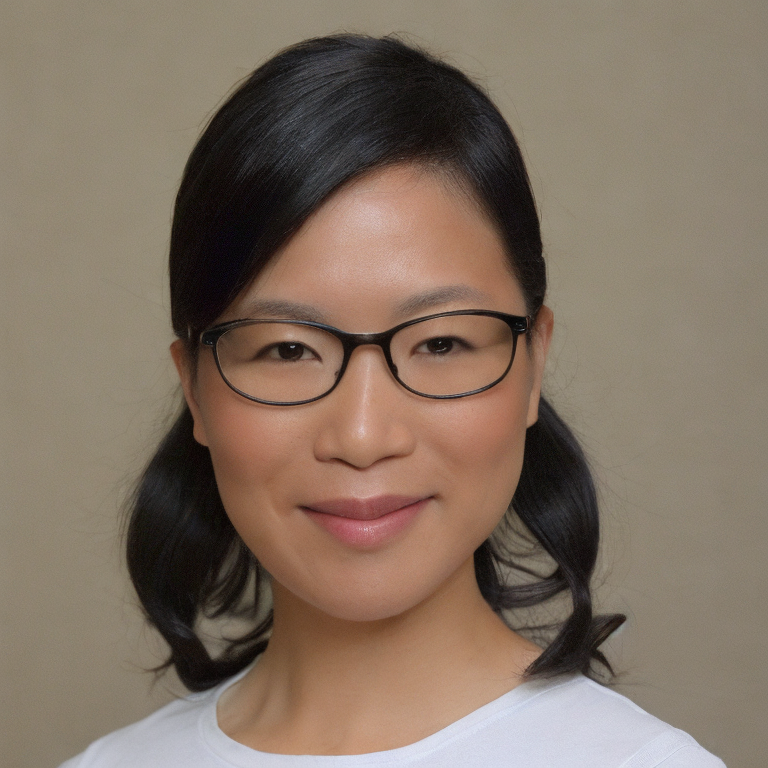

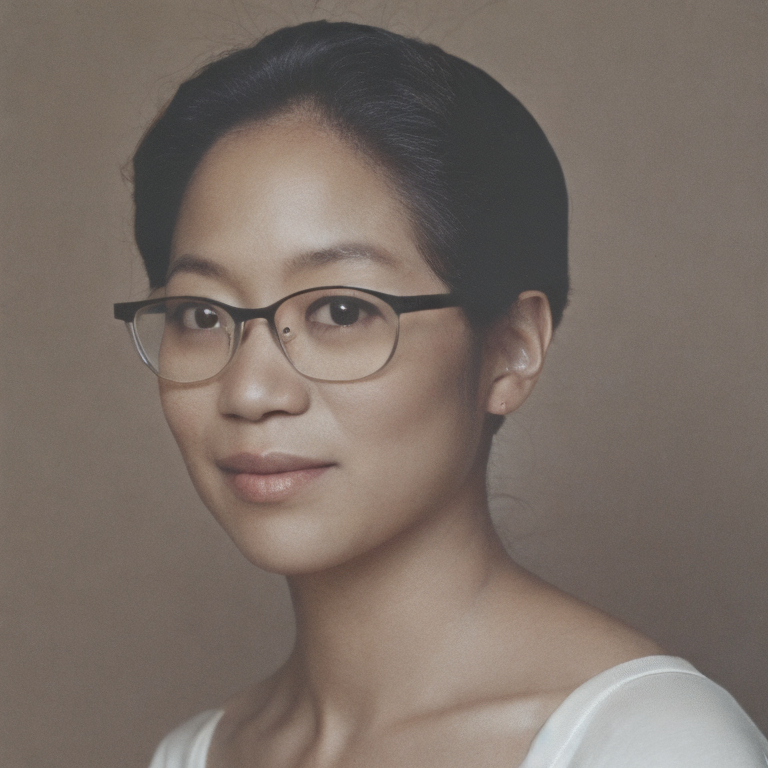

In [31]:
import os, time, torch
from diffusers import DiffusionPipeline
from IPython.display import Image, display

MODEL_ID = "LanguageMachines/stable-diffusion-2-1"

pipe = DiffusionPipeline.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float16
).to("cuda")

pipe.enable_attention_slicing()

NEGATIVE_PROMPT = (
    "cross-eyed, lazy eye, misaligned eyes, asymmetrical eyes, looking away, side glance, warped pupils, distorted face, extra eyes, deformed, bad anatomy, uncanny, cartoon, anime, illustration, low-res, blurry, out of focus, harsh shadows, overexposed, underexposed, open mouth, teeth, extra people, cluttered background, watermark, text, logo"
)

IMAGE_PROMPT = (
    "Photorealistic head-and-shoulders portrait of a 29-year-old East Asian woman, warm light skin tone, "
    "oval face, straight dark hair (center part, tucked behind ears, shoulder-length), "
    "thin rectangular matte-black glasses, minimal natural makeup, small silver stud earrings. "
    "Wearing a plain white crew-neck t-shirt under a light gray-beige unstructured jacket. "
    "Calm friendly teacher demeanor with a relaxed natural smile, looking directly at the camera. "
    "Soft natural front/45-degree lighting, evenly lit, gentle shadows. "
    "Simple smooth warm-beige background. Sharp focus, realistic skin texture."
)

def generate_avatar_image(prompt, num_steps=16, guidance=6.5):
    os.makedirs("examples/source_image/batch", exist_ok=True)
    img = pipe(
        prompt=prompt,
        negative_prompt=NEGATIVE_PROMPT,
        num_inference_steps=num_steps,
        guidance_scale=guidance
    ).images[0]
    path = f"examples/source_image/batch/avatar_{int(time.time()*1000)}.png"
    img.save(path)
    return path

paths = [generate_avatar_image(IMAGE_PROMPT) for _ in range(2)]
print("Saved:", paths)

for p in paths:
    display(Image(filename=p))

In [32]:
import os, shutil

src = "examples/source_image/batch/avatar_1770784198331.png"
dst = "examples/source_image/avatar_v1.png"

os.makedirs("examples/source_image", exist_ok=True)
shutil.copy(src, dst)
print("Saved canonical:", dst)

Saved canonical: examples/source_image/avatar_v1.png


In [33]:
from PIL import Image
import os

os.makedirs("examples/source_image", exist_ok=True)

img = Image.open("examples/source_image/avatar_v1.png")
w, h = img.size

# Square (profile) — centered crop
side = min(w, h)
left = (w - side) // 2
top = (h - side) // 2
sq = img.crop((left, top, left + side, top + side)).resize((1024, 1024))
sq.save("examples/source_image/avatar_v1_square.png")

# 9:16 vertical — centered crop
target_w = int(h * 9 / 16)
left = max(0, (w - target_w) // 2)
vert = img.crop((left, 0, left + target_w, h)).resize((1080, 1920))
vert.save("examples/source_image/avatar_v1_9x16.png")

# 16:9 wide — centered crop
target_h = int(w * 9 / 16)
top = max(0, (h - target_h) // 2)
wide = img.crop((0, top, w, top + target_h)).resize((1920, 1080))
wide.save("examples/source_image/avatar_v1_16x9.png")

print("Saved:",
      "examples/source_image/avatar_v1_square.png,",
      "examples/source_image/avatar_v1_9x16.png,",
      "examples/source_image/avatar_v1_16x9.png")

Saved: examples/source_image/avatar_v1_square.png, examples/source_image/avatar_v1_9x16.png, examples/source_image/avatar_v1_16x9.png


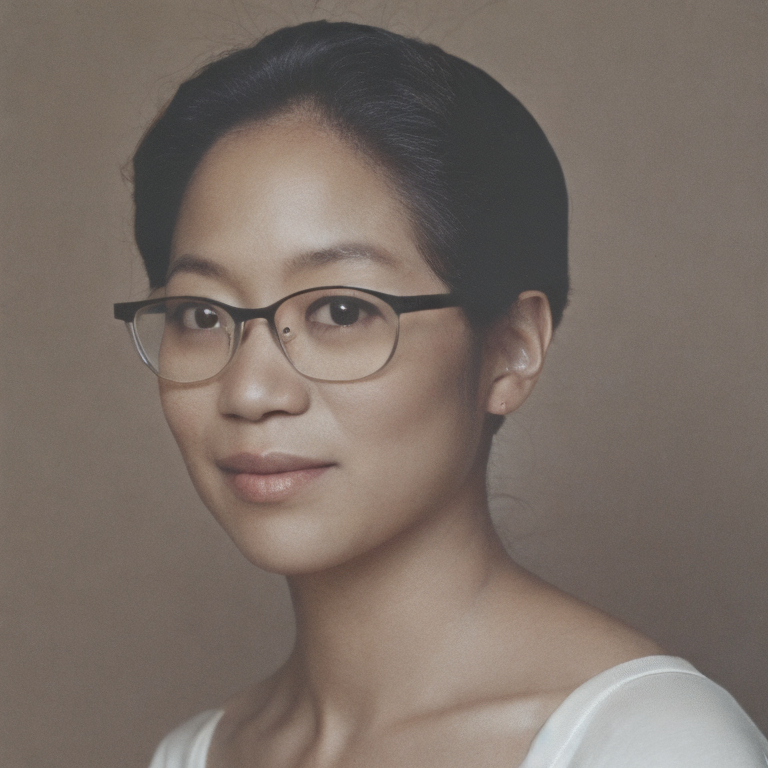

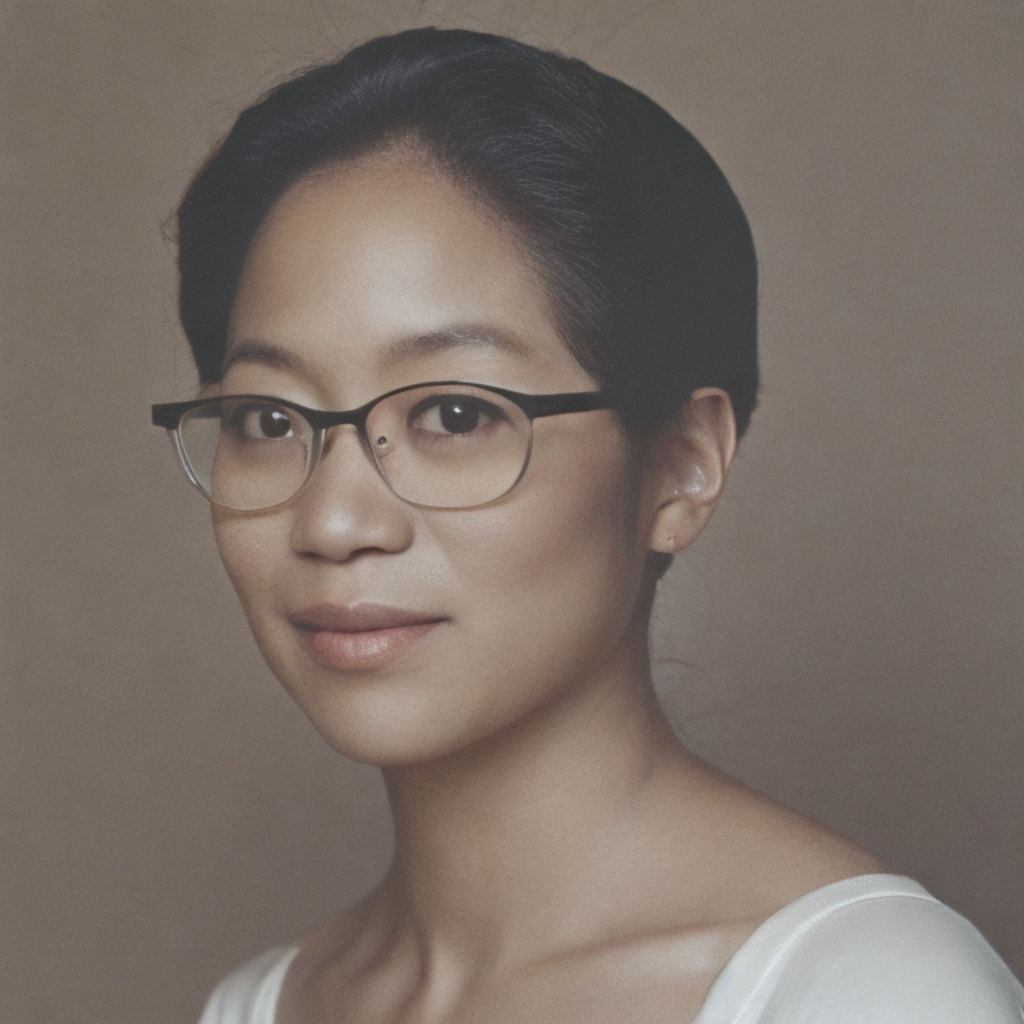

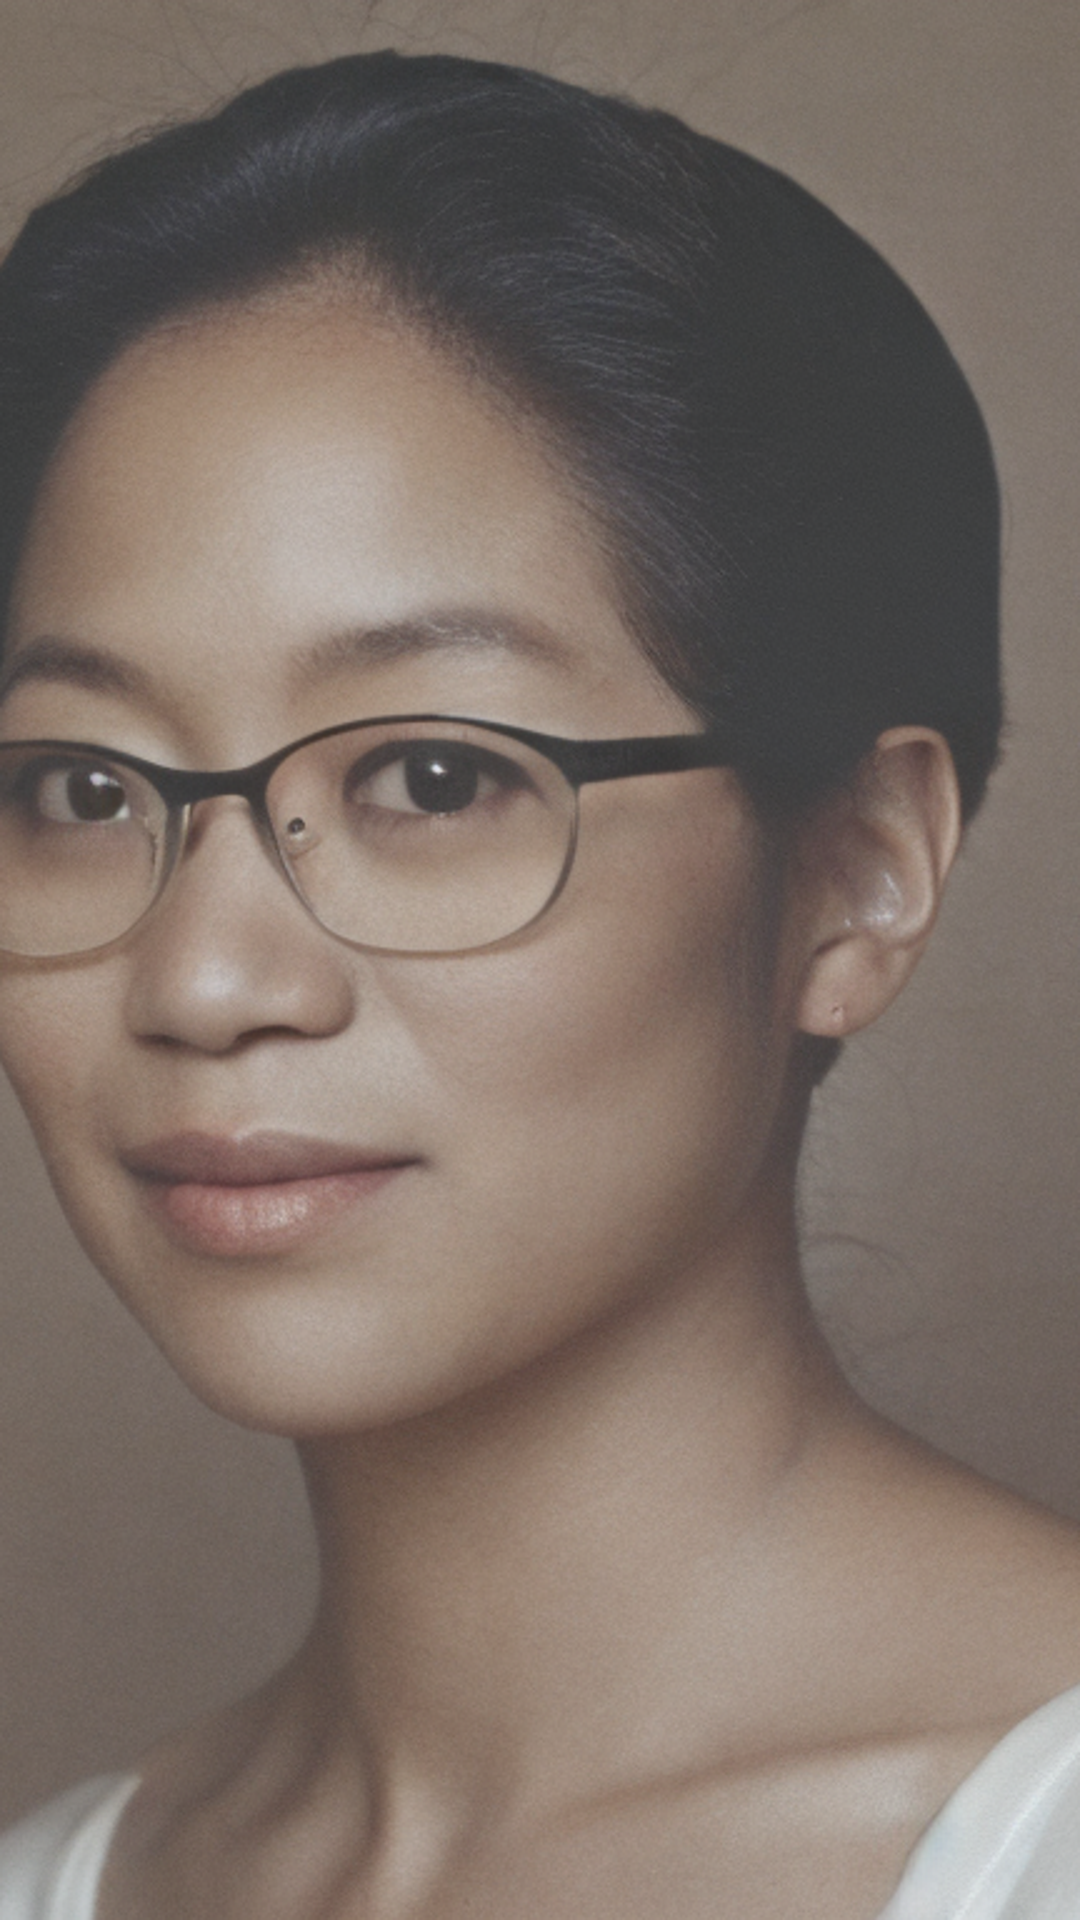

In [34]:
from IPython.display import Image, display
display(Image(filename="examples/source_image/avatar_v1.png"))
display(Image(filename="examples/source_image/avatar_v1_square.png"))
display(Image(filename="examples/source_image/avatar_v1_9x16.png"))

In [35]:
# Step 2 (Voice): Generate the invoice reminder voiceover to the exact path your pipeline expects

from gtts import gTTS
import os

def generate_voiceover(text: str, wav_path: str):
    """
    Generate a mono 16kHz WAV voiceover (good default for lip-sync pipelines).
    """
    os.makedirs(os.path.dirname(wav_path), exist_ok=True)

    tts = gTTS(text=text, lang="en", slow=False)
    tmp_mp3 = "temp_voice.mp3"
    tts.save(tmp_mp3)

    # Ensure ffmpeg exists
    os.system("ffmpeg -version >/dev/null 2>&1 || echo 'ffmpeg missing'")

    # Convert to 16kHz mono WAV
    os.system(f'ffmpeg -y -i "{tmp_mp3}" -ar 16000 -ac 1 "{wav_path}"')
    os.remove(tmp_mp3)

    print("Saved voiceover:", wav_path)


# --- Invoice reminder script (65–80s master) ---
invoice_script = (
    "Small business owners—here’s the fastest way to get paid without sounding aggressive. "
    "Copy this template and replace the brackets. "
    "Subject: Quick check-in on invoice number [number]. "
    "Message: Hi [name], quick check-in on invoice [number] for [amount]. It may have slipped through. "
    "If payment is already in progress, you can ignore this. If not, what’s the best date I should expect it? "
    "Now here’s the pro tweak: add one payment link so they don’t have to think. "
    "You can add: I can resend the invoice or you can pay here: [link]. "
    "That’s it. Short, polite, assumes good intent, and asks for a specific date. "
    "Comment P A I D and I’ll send the full invoice reminder pack."
)

voice_path = "examples/driven_audio/audio.wav"
generate_voiceover(invoice_script, voice_path)



Saved voiceover: examples/driven_audio/audio.wav


In [6]:
# Step 2: One-cell setup + run SadTalker (Colab)
# Assumes you already have:
# - examples/source_image/avatar_v1.png
# - examples/driven_audio/audio.wav
# - SadTalker repo with inference.py in the current working dir

import glob, os
from IPython.display import HTML
from base64 import b64encode

results_dir = "/content/SadTalker/results"

print("Results dir exists:", os.path.exists(results_dir))
if os.path.exists(results_dir):
    items = os.listdir(results_dir)
    print("Top-level results contents (first 50):", items[:50])

mp4s = sorted(
    glob.glob(results_dir + "/**/*.mp4", recursive=True),
    key=os.path.getmtime
)

print("Found MP4s:", mp4s)
assert mp4s, "No MP4 outputs found under /content/SadTalker/results. Open the Files sidebar and check what's inside results/."

latest = mp4s[-1]
print("Latest video:", latest)

mp4 = open(latest, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(f"""
<video width=420 controls>
  <source src="{data_url}" type="video/mp4">
</video>
""")

Results dir exists: True
Top-level results contents (first 50): []
Found MP4s: []


AssertionError: No MP4 outputs found under /content/SadTalker/results. Open the Files sidebar and check what's inside results/.

In [3]:
import os, sys

os.chdir("/content/SadTalker")

image_path = "/content/SadTalker/examples/source_image/avatar_v1.png"
audio_path = "/content/SadTalker/examples/driven_audio/audio.wav"
results_dir = "/content/SadTalker/results"
os.makedirs(results_dir, exist_ok=True)

cmd = f'''python3 inference.py \
  --driven_audio "{audio_path}" \
  --source_image "{image_path}" \
  --result_dir "{results_dir}" \
  --still --preprocess full --enhancer gfpgan 2>&1 | tee /content/SadTalker/inference_log.txt
'''
print(cmd)
!bash -lc "$cmd"

python3 inference.py   --driven_audio "/content/SadTalker/examples/driven_audio/audio.wav"   --source_image "/content/SadTalker/examples/source_image/avatar_v1.png"   --result_dir "/content/SadTalker/results"   --still --preprocess full --enhancer gfpgan 2>&1 | tee /content/SadTalker/inference_log.txt

Traceback (most recent call last):
  File "/content/SadTalker/inference.py", line 8, in <module>
    from src.utils.preprocess import CropAndExtract
  File "/content/SadTalker/src/utils/preprocess.py", line 9, in <module>
    from src.face3d.util.preprocess import align_img
  File "/content/SadTalker/src/face3d/util/preprocess.py", line 12, in <module>
    warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
                                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/numpy/__init__.py", line 410, in __getattr__
    raise AttributeError("module {!r} has no attribute "
AttributeError: module 'numpy' has no

In [7]:
import os, glob, time, subprocess, textwrap

# Paths
sad_dir = "/content/SadTalker"
image_path = "/content/SadTalker/examples/source_image/avatar_v1.png"
audio_path = "/content/SadTalker/examples/driven_audio/audio.wav"
results_dir = "/content/SadTalker/results"
os.makedirs(results_dir, exist_ok=True)

assert os.path.exists(image_path), f"Missing image: {image_path}"
assert os.path.exists(audio_path), f"Missing audio: {audio_path}"

# Snapshot "before" state
before = set(glob.glob(results_dir + "/**/*.mp4", recursive=True))
t0 = time.time()
print("MP4s before:", sorted(before))

# Run inference WITH streamed logs
cmd = textwrap.dedent(f"""
cd "{sad_dir}"
python3 inference.py \
  --driven_audio "{audio_path}" \
  --source_image "{image_path}" \
  --result_dir "{results_dir}" \
  --still --preprocess full --enhancer gfpgan 2>&1 | tee "{sad_dir}/inference_log_latest.txt"
""").strip()

print("\nRunning inference:\n", cmd, "\n")
subprocess.run(["bash", "-lc", cmd], check=True)

# Snapshot "after" state
after = set(glob.glob(results_dir + "/**/*.mp4", recursive=True))
new_mp4s = sorted([p for p in after - before if os.path.getmtime(p) >= t0 - 2])

print("\nMP4s after:", sorted(after))
print("\nNEW MP4s:", new_mp4s)

if not new_mp4s:
    print("\n❌ No new MP4 created. Listing results dir:")
    for root, dirs, files in os.walk(results_dir):
        print(root, "files:", files[:20])
else:
    print("\n✅ Created:", new_mp4s[-1])

MP4s before: []

Running inference:
 cd "/content/SadTalker"
python3 inference.py   --driven_audio "/content/SadTalker/examples/driven_audio/audio.wav"   --source_image "/content/SadTalker/examples/source_image/avatar_v1.png"   --result_dir "/content/SadTalker/results"   --still --preprocess full --enhancer gfpgan 2>&1 | tee "/content/SadTalker/inference_log_latest.txt" 


MP4s after: []

NEW MP4s: []

❌ No new MP4 created. Listing results dir:
/content/SadTalker/results files: []


In [11]:
!pip install --upgrade torch==2.2.2+cu121 torchvision==0.17.2+cu121 torchaudio==2.2.2+cu121 --index-url https://download.pytorch.org/whl/cu121
import torch, torchvision
print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.2/757.2 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 112.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 109.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/19

In [5]:
import textwrap, subprocess

cmd = textwrap.dedent(r'''
cd /content/SadTalker
python3 inference.py \
  --driven_audio "/content/SadTalker/examples/driven_audio/audio.wav" \
  --source_image "/content/SadTalker/examples/source_image/avatar_v1.png" \
  --result_dir "/content/SadTalker/results" \
  --still --preprocess full --enhancer gfpgan 2>&1 | tee /content/SadTalker/inference_log2.txt
''').strip()

print(cmd)
subprocess.check_call(["bash", "-lc", cmd])

cd /content/SadTalker
python3 inference.py \
  --driven_audio "/content/SadTalker/examples/driven_audio/audio.wav" \
  --source_image "/content/SadTalker/examples/source_image/avatar_v1.png" \
  --result_dir "/content/SadTalker/results" \
  --still --preprocess full --enhancer gfpgan 2>&1 | tee /content/SadTalker/inference_log2.txt


0

In [ ]:
from IPython.display import HTML
from base64 import b64encode
import glob, os

mp4s = sorted(glob.glob("./results/*.mp4"), key=os.path.getmtime)
assert mp4s, "No .mp4 files found in ./results — check inference output above."
latest = mp4s[-1]
print("Latest video:", latest)

mp4 = open(latest, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width=420 controls>
  <source src="{data_url}" type="video/mp4">
</video>
""")




In [ ]:
def init(avatar_details, script):

    """Function to generate ai influencer videos by first generating the avatar image using
    the prompt and the characterstics and then generating the voiceover using script.
    With these generated image and voiceover, AI influencer video is generated.

    parameters:
    avatar_details (dict) : characterstics of the avatar
    script (str) : script to generate the voiceover

    returns:
    res (list) : list of the generated files in the folder
    """
    characterstics = avatar_details.get('characterstics')
    prompt = get_prompt_for_image(characterstics)
    print("Image prompt: " + prompt)
    avatar_image_url = generate_avatar_image(prompt)
    print("avatar_image_url: " + avatar_image_url)
    voice_path = "examples/driven_audio/audio.wav"
    generate_voiceover(script,voice_path)

    res = create_ai_influencer(avatar_image_url,voice_path)
    print(res)


### Init function to generate the Influencer video
init({'characterstics':'male European, wearing glasses and leather jacket with a smile on face'}, "Our planet is a masterpiece of life, a delicate balance of ecosystems. But this harmony is under threat.Every year, 8 million tons of plastic enter our oceans, choking marine life. Forests, the lungs of our planet, are disappearing at an alarming rate. Climate change fuels disasters, from rising seas to devastating wildfires.But there is hope. Across the globe, people are rising to the challenge. Simple actions—reducing waste, conserving energy, and protecting wildlife—can make a difference.The future of our planet is in our hands. Together, we can turn the tide and protect our only home. Act now, because every choice matters.")
